Random Forest Model

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv("Data\label_encoded_dataset.csv")
df.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,6,77516,9,4,0,1,4,1,2174,0,40,38,0
1,50,5,83311,9,2,3,0,4,1,0,0,20,38,0
2,38,3,215646,11,0,5,1,4,1,0,0,40,38,0
3,53,3,234721,1,2,5,0,2,1,0,0,40,38,0
4,28,3,338409,9,2,9,5,2,0,0,0,40,4,0


In [3]:
# Splitting the dataset into training and testing sets
x = df.drop('income', axis=1)
y = df['income']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train, y_train)

# Make predictions on the testing data
y_prediction = rf_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_prediction)
report = classification_report(y_test, y_prediction)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.8398950131233596
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.90      7170
           1       0.72      0.58      0.64      2355

    accuracy                           0.84      9525
   macro avg       0.79      0.75      0.77      9525
weighted avg       0.83      0.84      0.83      9525



In [14]:
# Training accuracy
training_accuracy = rf_model.score(x_train, y_train)
print("Training Accuracy:", training_accuracy)

# Testing accuracy
testing_accuracy = rf_model.score(x_test, y_test)
print("Testing Accuracy:", testing_accuracy)

Training Accuracy: 0.999317513649727
Testing Accuracy: 0.8398950131233596


In [16]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_prediction)

# Print the confusion matrix in text form
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[6618  552]
 [ 977 1378]]


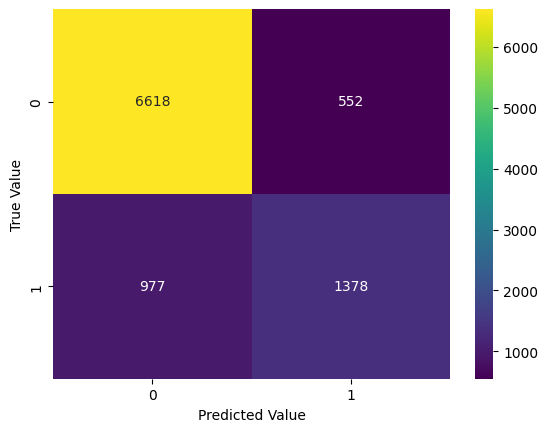

In [15]:
# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_prediction), annot=True, cmap='viridis', fmt='d')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()